In [20]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import test_accuracies
from network import exponential_graph, null_graph, get_alphas
from optimization import local_FW, gd_reg_local_FW, centralized_FW, regularized_local_FW
from utils import generate_fixed_moons, load_harws, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

## Moons

In [21]:
# set graph of nodes with local personalized data
NB_ITER = 10000
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017

BETA = 10

K, X, Y, X_test, Y_test, max_nb_instances, theta_true, angles, groundtruth_adj_matrix = generate_fixed_moons(D, sample_error_rate=NOISE_R, rnd_state=2017)

# set graph
nodes, adj_matrix, similarities = exponential_graph(X, Y, X_test, Y_test, K, theta_true, max_nb_instances)

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

colors = {
    "Local-Adaboost": "k",
    "Dada-Learned": "c",  
    "Dada-Fixed": "b",
}

In [22]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Global-Adaboost"] = {}
results["Global-Adaboost"]["test-accuracies"] = test_accuracies(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["test-accuracies"] = test_accuracies(local_nodes)

In [23]:
dada_nodes = deepcopy(nodes)
gd_reg_local_FW(dada_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": 20000, 
                    "args":(0.1, 1)}, beta=BETA, mu=0.1, nb_iter=NB_ITER, monitors={})
results["Dada-Learned"] = {}
results["Dada-Learned"]["test-accuracies"] = test_accuracies(dada_nodes)

../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))


In [24]:
fixed_nodes = deepcopy(nodes)
regularized_local_FW(fixed_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=1, monitors={})
results["Dada-Fixed"] = {}
results["Dada-Fixed"]["test-accuracies"] = test_accuracies(fixed_nodes)

In [25]:
train_points = np.asarray([len(n.sample) for n in nodes])
train_points_set = np.unique(train_points)

for k in colors.keys():
    results[k]["test-by-points"] = []

for t in train_points_set:
    inds = [train_points == t]
    
    for k in colors.keys():
        test_by_inds = np.asarray(results[k]["test-accuracies"])[inds]
        results[k]["test-by-points"].append(sum(test_by_inds) / len(test_by_inds))

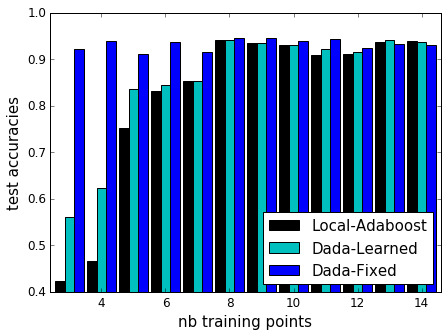

In [26]:
WIDTH = 0.3

plt.figure(1, figsize=(7, 5))

plt.xlabel('nb training points', fontsize=15)
plt.ylabel('test accuracies', fontsize=15)
plt.xlim(min(train_points_set)-2*WIDTH, max(train_points_set)+2*WIDTH)
plt.ylim(0.4, 1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

lag = -WIDTH
for k, c in colors.items():
    plt.bar(train_points_set + lag, results[k]["test-by-points"], width=WIDTH, color=c, label=k, align="center")
    lag += WIDTH

plt.legend(loc='lower right', fontsize=15)

plt.savefig("moons-clust-points.pdf", bbox_inches="tight")

## HARWS

In [27]:
# set graph of nodes with local personalized data
NB_ITER = 1000
n = 1122

BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_harws(path="../datasets/", walking=True)
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [28]:
# centralized_nodes = deepcopy(nodes)
# centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
# results["Global-Adaboost"] = {}
# results["Global-Adaboost"]["test-accuracies"] = test_accuracies(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["test-accuracies"] = test_accuracies(local_nodes)

In [29]:
dada_nodes = deepcopy(nodes)
gd_reg_local_FW(dada_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": 200, 
                    "args":(0.001, 0.1)}, beta=BETA, mu=0.001, nb_iter=NB_ITER, monitors={})
results["Dada-Learned"] = {}
results["Dada-Learned"]["test-accuracies"] = test_accuracies(dada_nodes)

../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))


In [30]:
colors = {
    "Local-Adaboost": "k",
    "Dada-Learned": "c",
}

train_points = np.asarray([len(n.sample) for n in nodes])
train_points_set = np.unique(train_points)

for k in colors.keys():
    results[k]["test-by-points"] = []

for t in train_points_set:
    inds = [train_points == t]
    
    for k in colors.keys():
        test_by_inds = np.asarray(results[k]["test-accuracies"])[inds]
        results[k]["test-by-points"].append(sum(test_by_inds) / len(test_by_inds))

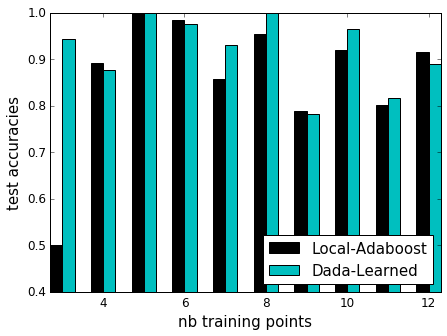

In [31]:
WIDTH = 0.3

plt.figure(1, figsize=(7, 5))

plt.xlabel('nb training points', fontsize=15)
plt.ylabel('test accuracies', fontsize=15)
plt.xlim(min(train_points_set)-WIDTH, max(train_points_set)+WIDTH)
plt.ylim(0.4, 1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

lag = -WIDTH/2
for k, c in colors.items():
    plt.bar(train_points_set + lag, results[k]["test-by-points"], width=WIDTH, color=c, label=k, align="center")
    lag += WIDTH

plt.legend(loc='lower right', fontsize=15)

plt.savefig("harws-points.pdf", bbox_inches="tight")